# Jupyter Notebook of Carlos Moreno Fernandez

Here is the Jupyter Notebook that you can use to run your code. Remember that you data needs to be uploaded to the GitHub repository before you can use it. I recommend you to upload in the folder called *StudentProjects*.

There are a lot of information on how to use Jupyter Notebook on Internet. Here, I will add a small list of actions:
* Use the *Insert* menu to insert new cells
* Use the *Cell/Cell type* menu to change the style of a given cell: *Code* if you want to add Python code and *Markdown* if you want to add an informative cell
* Each cell can be executed individually. Then I recommend to include limited number of code lines in each of them.
* Use the *Edit* menu to delete cells.
* Remember to save your code once you add it.
* If when you run your code, you have errors due to libraries not included in the repository, please contact me.

If you have questions regarding the environment, please email me or use Teams.

In [1]:
# We would require again the following libraries to manage our dataset
# Numpy: used for large, multi-dimensional arrays and matrices, and for high-level mathematical functions
# Pandas: used for data manipulation and analysis
import pandas as pd
import numpy as np
# We will use a new library for machine learning, Scikit-learn. 
# This library allows us to implement easily machine learning models and operations over them. 
# This time we will use the predefined function to scale (min-max normalisation) our data
from sklearn.preprocessing import MinMaxScaler
# we will use the same library to divide our dataset in train and testing
from sklearn.model_selection import train_test_split
# We will import the functions to deal with a linear model.
import sklearn.linear_model as skl_lm
# and a function that calculates the performance
from sklearn.metrics import mean_squared_error
# We will use also another library to plot our model
import matplotlib.pyplot as plt

from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder

In [2]:
# header: indicates if the dataset has an initial line with the name of each column
dataset = pd.read_csv('Computer-Hardware-Dataset-data-header.csv', header=0)

In [3]:
dataset

,adviser,32/60,125,256,6000,256.1,16,128,198,199
0,amdahl,470v/7,29,8000,32000,32,8,32,269,253
1,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
2,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
3,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
4,amdahl,470v/b,26,8000,32000,64,8,32,318,290
...,...,...,...,...,...,...,...,...,...,...
203,sperry,80/8,124,1000,8000,0,1,8,42,37
204,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
205,sratus,32,125,2000,8000,0,2,14,52,41
206,wang,vs-100,480,512,8000,32,0,0,67,47


In [4]:
dataset.head(20)

,adviser,32/60,125,256,6000,256.1,16,128,198,199
0,amdahl,470v/7,29,8000,32000,32,8,32,269,253
1,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
2,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
3,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
4,amdahl,470v/b,26,8000,32000,64,8,32,318,290
5,amdahl,580-5840,23,16000,32000,64,16,32,367,381
6,amdahl,580-5850,23,16000,32000,64,16,32,489,381
7,amdahl,580-5860,23,16000,64000,64,16,32,636,749
8,amdahl,580-5880,23,32000,64000,128,32,64,1144,1238
9,apollo,dn320,400,1000,3000,0,1,2,38,23


In [ ]:
print(dataset.describe())

In [ ]:
#Class Distribution
print(dataset.groupby('Vendor Name').size())

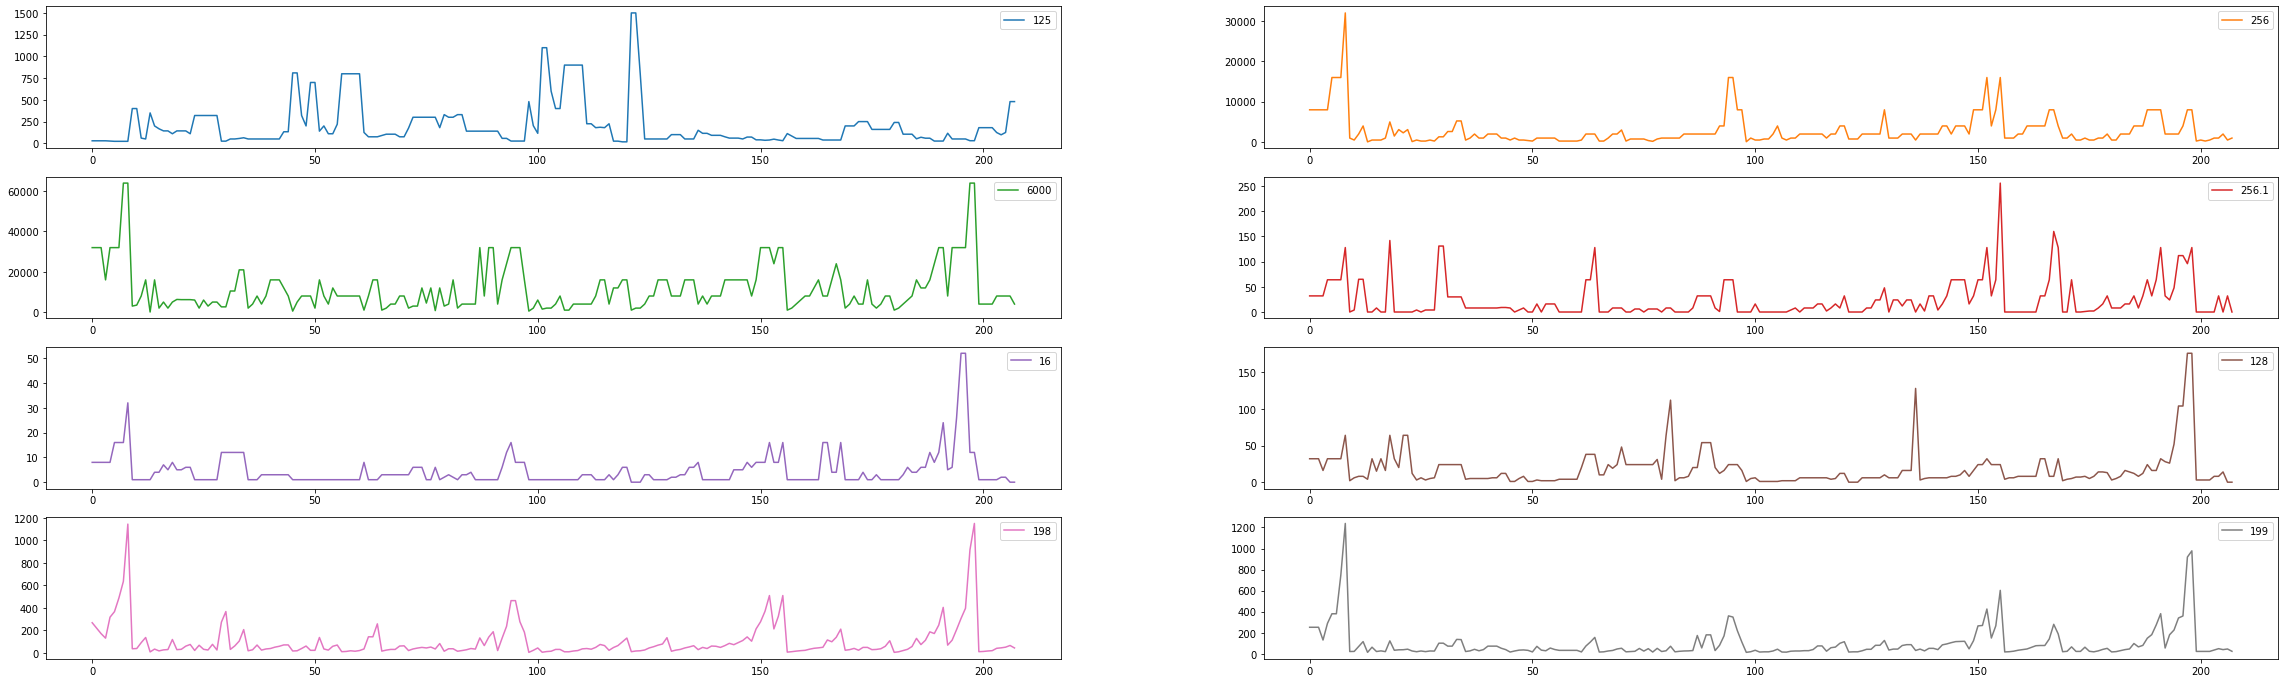

In [8]:
# box and whisker plots
dataset.plot(kind='line', subplots=True, layout=(4,2), sharex=False, sharey=False)
pyplot.rcParams['figure.figsize'] = [40, 12]
pyplot.show()

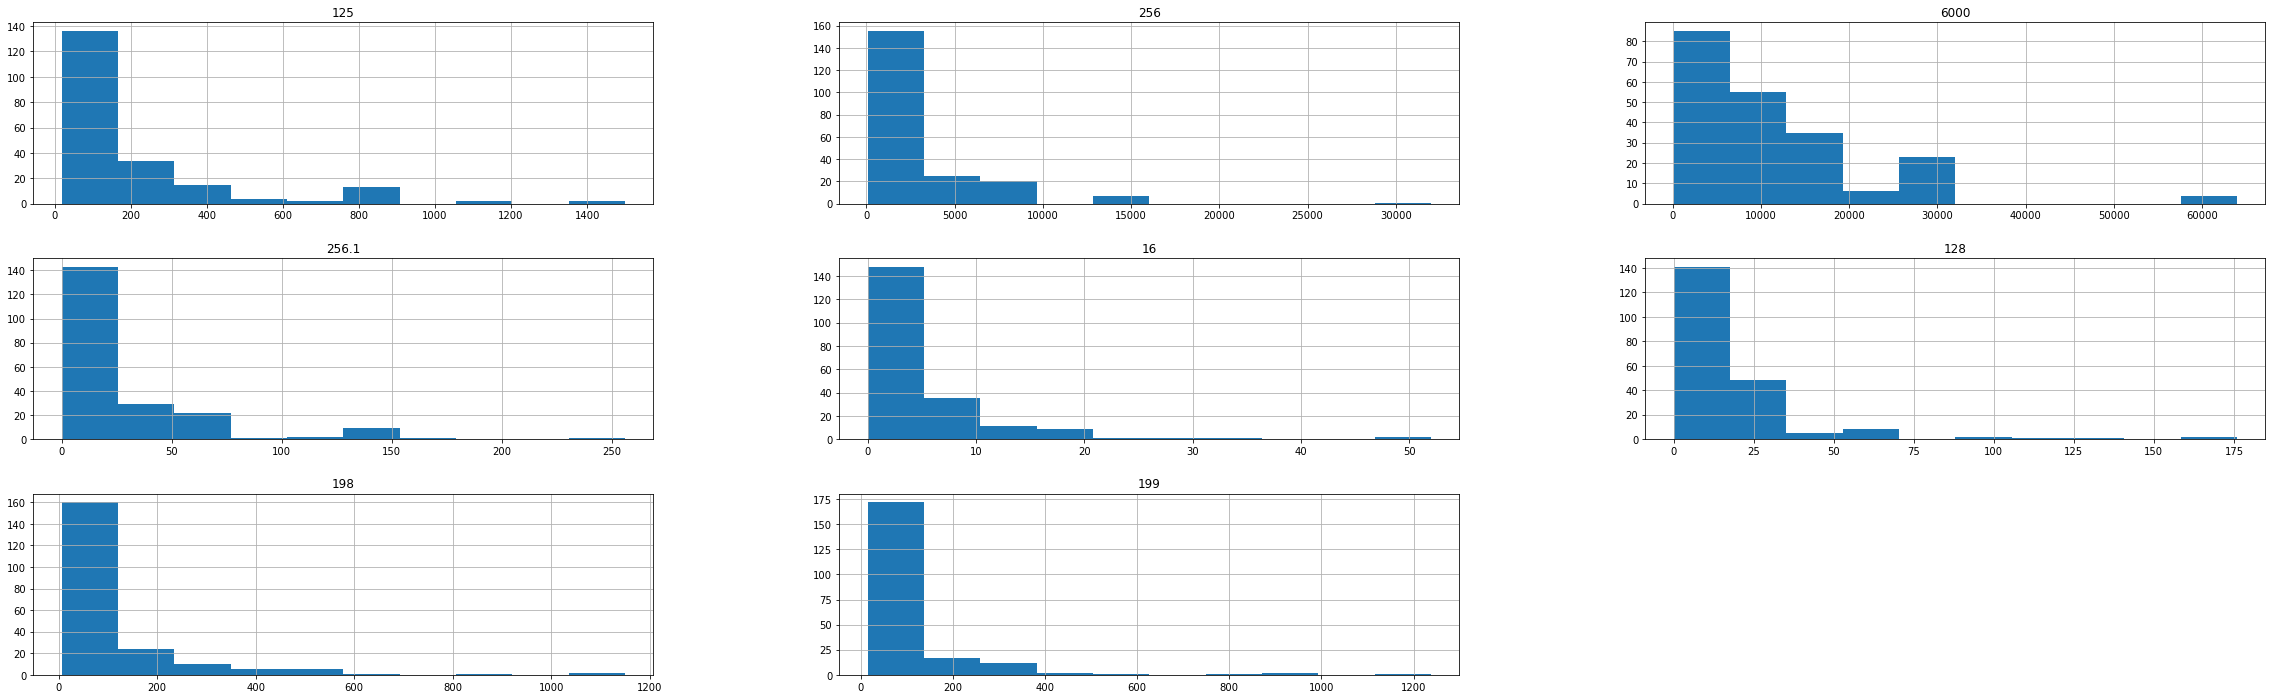

In [9]:
# histograms
dataset.hist()
pyplot.show()

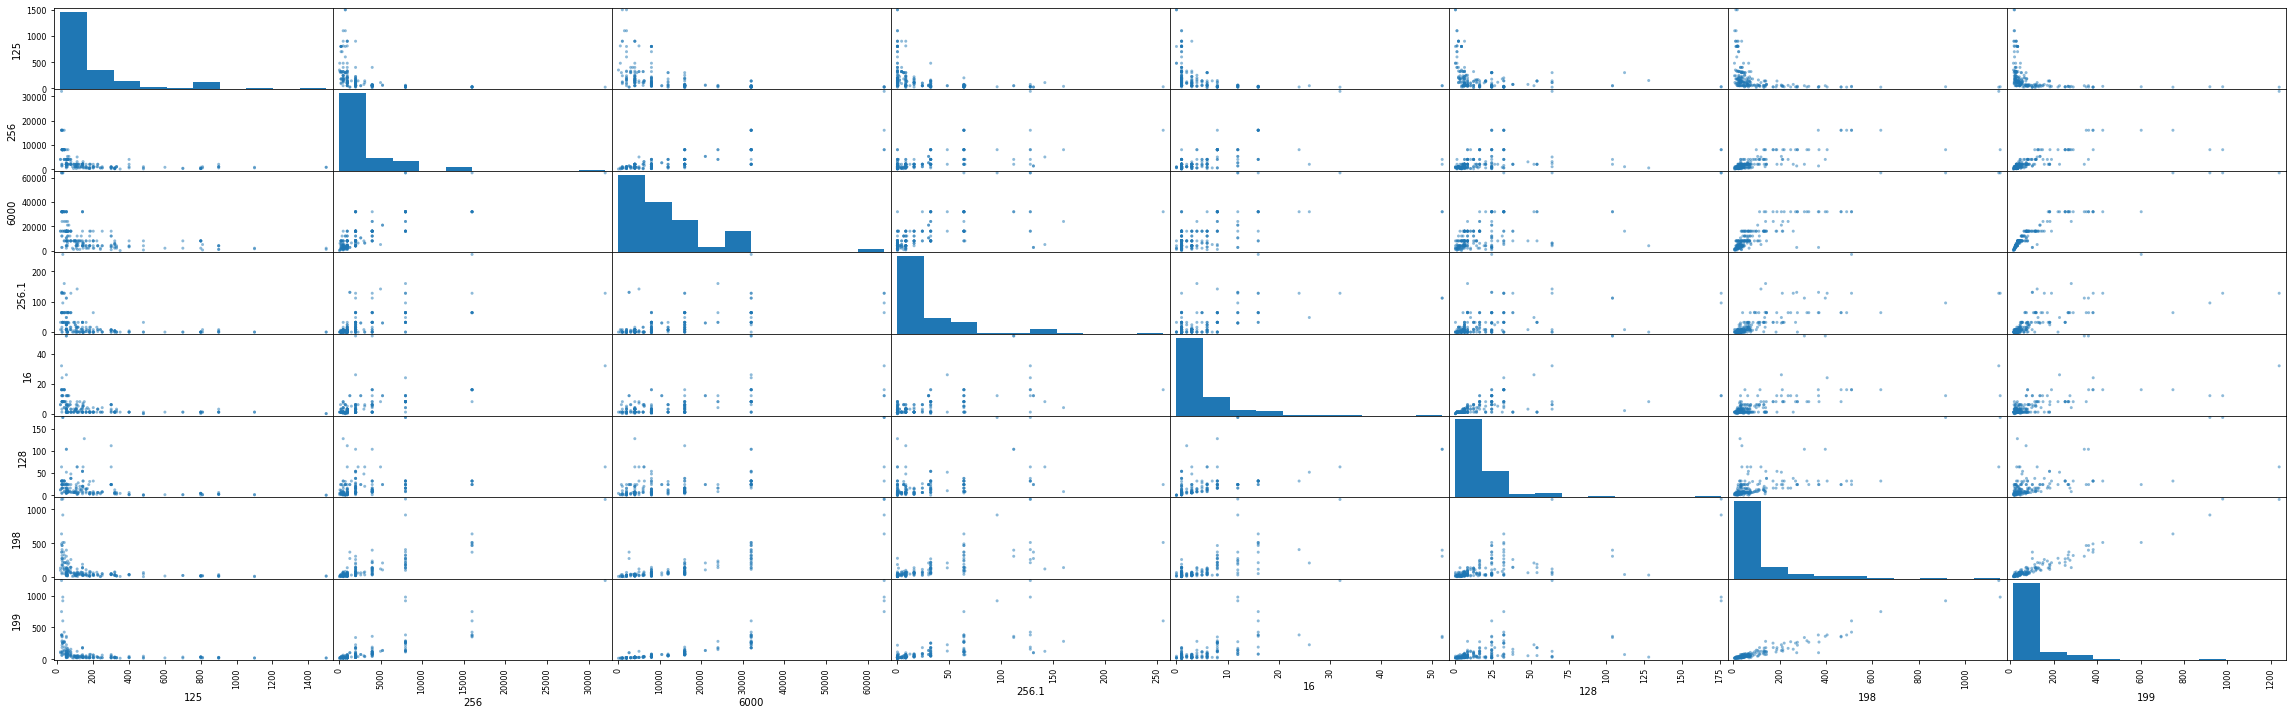

In [10]:
# scatter plot matrix
scatter_matrix(dataset)
pyplot.show()

In [38]:
# CHANGE!!!! Carlos, he cambiado y por Y en train_test_split ya que las labels estan en la variable en mayusculas
# Split-out validation dataset
array = dataset.values
X = array[:, 2:8]
Y = array[:, 8]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=1)
print (X)
print (Y)
print (X_train)
print (X_validation)
print (Y_train)
print (Y_validation)

[[29 8000 32000 32 8 32]
 [29 8000 32000 32 8 32]
 [29 8000 32000 32 8 32]
 ...
 [125 2000 8000 0 2 14]
 [480 512 8000 32 0 0]
 [480 1000 4000 0 0 0]]
[269 220 172 132 318 367 489 636 1144 38 40 92 138 10 35 19 28 31 120 30
 33 61 76 23 69 33 27 77 27 274 368 32 63 106 208 20 29 71 26 36 40 52 60
 72 72 18 20 40 62 24 24 138 36 26 60 71 12 14 20 16 22 36 144 144 259 17
 26 32 32 62 64 22 36 44 50 45 53 36 84 16 38 38 16 22 29 40 35 134 66 141
 189 22 132 237 465 465 277 185 6 24 45 7 13 16 32 32 11 11 18 22 37 40 34
 50 76 66 24 49 66 100 133 12 18 20 27 45 56 70 80 136 16 26 32 45 54 65
 30 50 40 62 60 50 66 86 74 93 111 143 105 214 277 370 510 214 326 510 8
 12 17 21 24 34 42 46 51 116 100 140 212 25 30 41 25 50 50 30 32 38 60 109
 6 11 22 33 58 130 75 113 188 173 248 405 70 114 208 307 397 915 1150 12
 14 18 21 42 46 52 67 45]
[[300 768 3000 6 6 24]
 [38 8000 16000 64 4 8]
 [115 2000 4000 2 1 5]
 [180 262 4000 0 1 3]
 [140 2000 4000 0 3 6]
 [140 2000 32000 32 1 54]
 [800 768 2000 0 

In [45]:
#print (np.shape(X))
#print (np.shape(Y))
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train)

0.8832517983047341

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []

for name, model in models:
	kfold = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
    